# Example working with EMIT over Libya-4

EMIT_L1B_RAD_001_20220827T091626_2223906_009

# SNR (Signal-to-noise-ratio)

In [274]:
import hyperquest

from spectral import *
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from sklearn.decomposition import PCA
import numpy as np

In [282]:
# Define path to envi image header file
path_to_data = '../tests/data/EMIT_L1B_RAD_001_20220827T091626_2223906_009.nc'


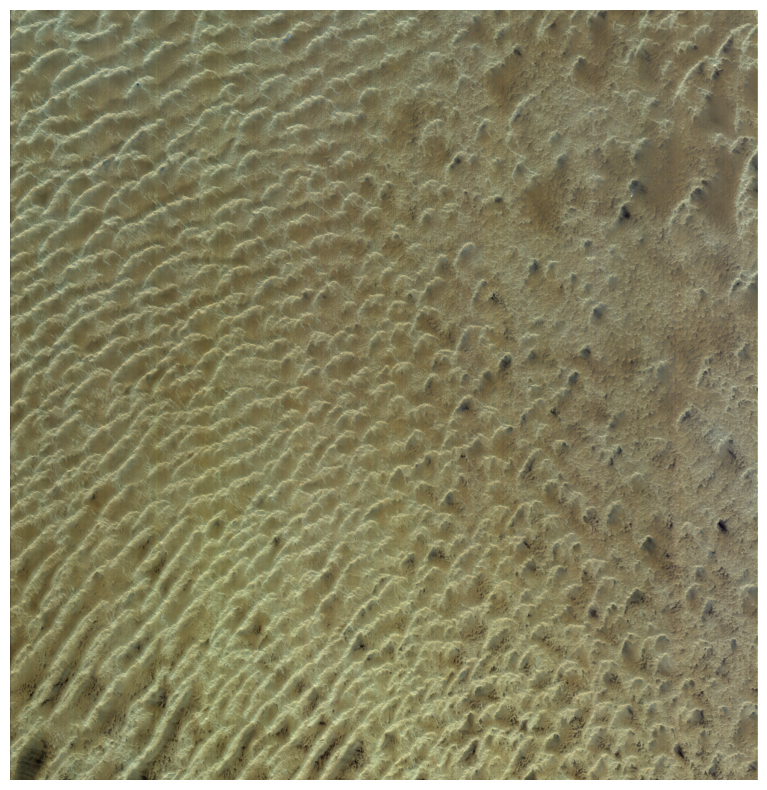

In [283]:
# Load raster
array, fwhm, wave, obs_time = hyperquest.retrieve_data_from_nc(path_to_data)
red = array[:,:,38]
blue = array[:,:,11]
green = array[:,:,24]

red= np.ma.masked_equal(red, -9999)
green = np.ma.masked_equal(green, -9999)
blue = np.ma.masked_equal(blue, -9999)

# Normalize the values for display
plt.figure(figsize=(10, 10))
red_normalized = (red - red.min()) / (red.max() - red.min())
green_normalized = (green - green.min()) / (green.max() - green.min())
blue_normalized = (blue - blue.min()) / (blue.max() - blue.min())
rgb_image = np.dstack((red_normalized, green_normalized, blue_normalized))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-26.275995515639153..29.37199569631798].


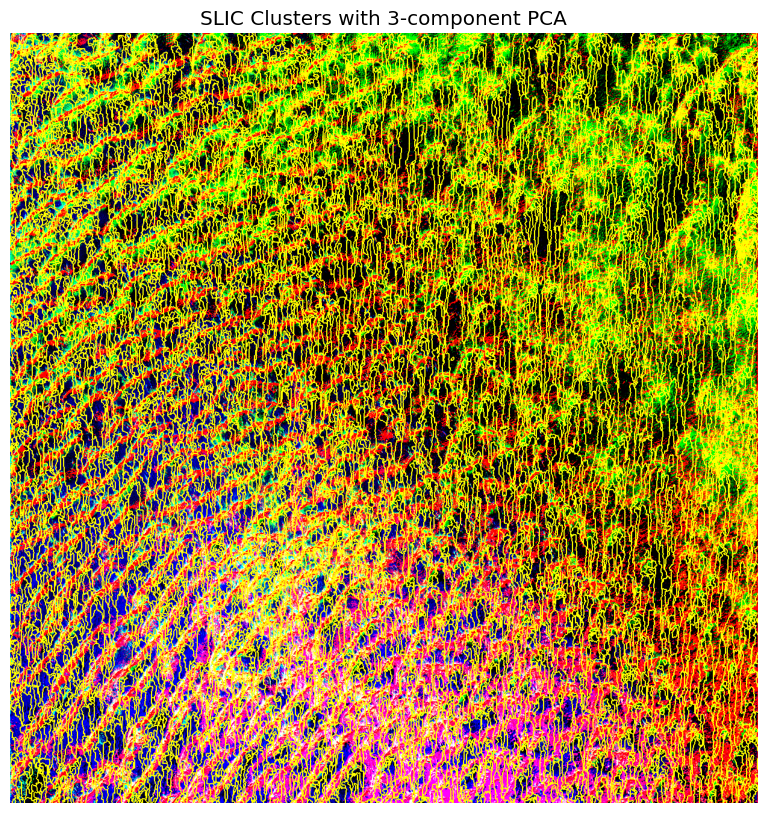

In [284]:
# first 3 components
pca = PCA(n_components=3)
rows, cols, bands = array.shape
array_reshaped = array.reshape(-1, bands)
array_pca = pca.fit_transform(array_reshaped).reshape(rows, cols, -1)

# SLIC
n_segments = 70000
compactness = 0.0005


segments = slic(array_pca, 
                n_segments=n_segments, 
                compactness=compactness)


plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(array_pca, segments))
plt.title("SLIC Clusters with 3-component PCA")
plt.axis("off")
plt.show()

In [309]:
# compute using HRDSDC method
snr, noise_variance = hyperquest.hrdsdc(path_to_data, 
                                        n_segments = n_segments, 
                                        compactness = compactness, 
                                        n_pca = 3, 
                                        ncpus = 8)

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


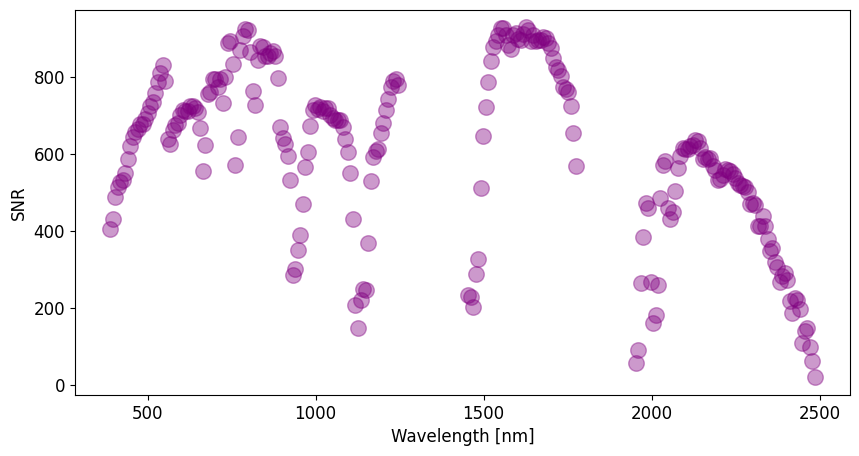

In [286]:
# comparable to Fig 23 in Thompson et al. (2023)
plt.figure(figsize= (10,5))
plt.rcParams.update({'font.size': 12})
plt.scatter(wave, snr, color='purple', s=125, alpha=0.4)
plt.xlabel('Wavelength [nm]')
plt.ylabel('SNR')
plt.show()

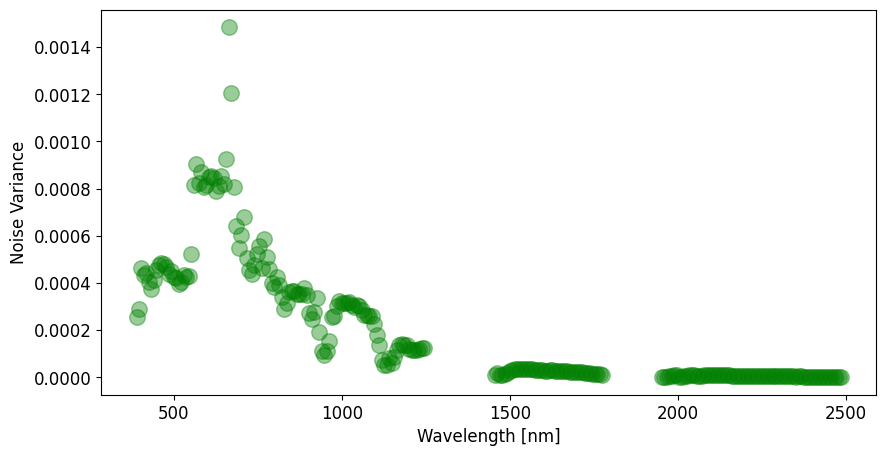

In [287]:
plt.figure(figsize= (10,5))
plt.scatter(wave, noise_variance, color='green', s=125, alpha=0.4)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Noise Variance')
plt.show()

# Smile (wavelength acccuracy)

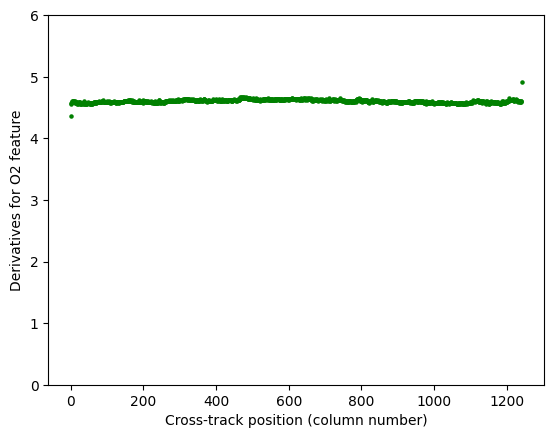

In [7]:
# running smile_metric()
o2_mean, co2_mean, o2_std, co2_std = hyperquest.smile_metric(path_to_data, rotate=0)

# column numbers can be made using the length of the result here
column_numbers = range(0, len(o2_mean))

# plotting
plt.scatter(column_numbers, o2_mean, color='green', s=5)
plt.ylabel('Derivatives for O2 feature')
plt.xlabel('Cross-track position (column number)')
plt.ylim(0,6)
plt.show()

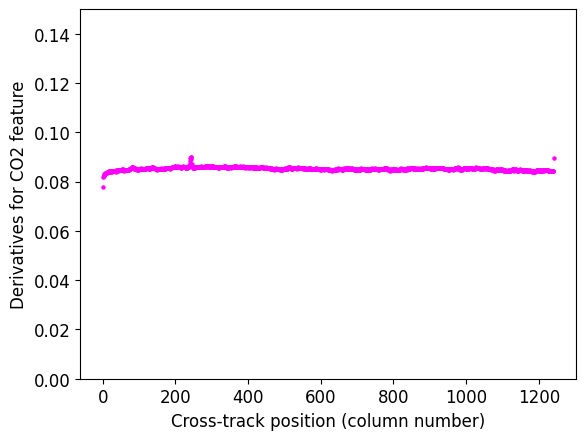

In [42]:
# plotting co2 now
plt.scatter(column_numbers, co2_mean, color='magenta', s=5)
plt.ylabel('Derivatives for CO2 feature')
plt.xlabel('Cross-track position (column number)')
plt.ylim(0, 0.15)
plt.show()

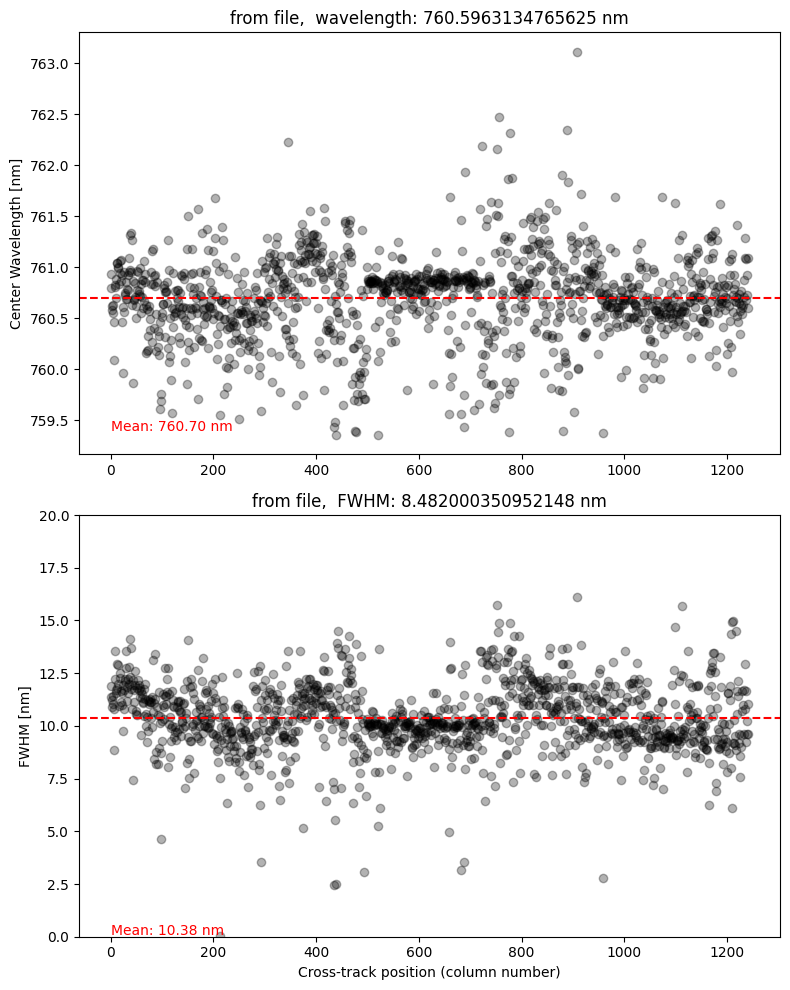

In [8]:
path_to_rtm_output_csv = '../tests/data/rtm-SISTER_EMIT_L1B_RDN_20220827T091626_000/radiative_transfer_output.csv'

cwl, fwhm, sensor_band, sensor_fwhm = hyperquest.nodd_o2a(path_to_data,
                                                          rotate = 0, 
                                                          path_to_rtm_output_csv = path_to_rtm_output_csv, 
                                                          rho_s=0.15, # can be assumed , exact reflectance is not needed in NODD
                                                          ncpus=8,
                                                          mask_waterbodies=True)

# outputs
# CWL: array of optimal CWL at sensor_band
# FWHM: array of optimal FWHM at sensor band
# sensor_band: value given in hdr for CWL closest to O2-A.
# sensor_fwhm: value given in hdr for FWHM closest to O2-A.

# means
mean_cwl = np.nanmean(cwl)
mean_fwhm = np.nanmean(fwhm)

# plot code
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

ax[0].scatter(column_numbers, cwl, color='k', alpha=0.3)
ax[0].axhline(mean_cwl, color='r', linestyle='--')
ax[0].text(0, 759.4, f'Mean: {mean_cwl:.2f} nm', color='r') 
ax[0].set_title(f'from file,  wavelength: {sensor_band} nm')
ax[0].set_xlabel('')
ax[0].set_ylabel('Center Wavelength [nm]')

ax[1].scatter(column_numbers, fwhm, color='k', alpha=0.3)
ax[1].axhline(mean_fwhm, color='r', linestyle='--')
ax[1].text(0, 0.1, f'Mean: {mean_fwhm:.2f} nm', color='r') 
ax[1].set_title(f'from file,  FWHM: {sensor_fwhm} nm')
ax[1].set_xlabel('Cross-track position (column number)')
ax[1].set_ylabel('FWHM [nm]')
ax[1].set_ylim(0,20)
plt.tight_layout()
plt.show()

https://hyspiri.jpl.nasa.gov/downloads/2017_Workshop/posters/5_KCawse_HyTES_Noise.pdf 